In [126]:
!kaggle datasets download sai14karthik/nasdq-dataset
!unzip /content/nasdq-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/sai14karthik/nasdq-dataset
License(s): apache-2.0
nasdq-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/nasdq-dataset.zip
replace nasdq.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [127]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

In [128]:
df = pd.read_csv('/content/nasdq.csv')
df.head()

,Date,Open,High,Low,Close,Volume,InterestRate,ExchangeRate,VIX,TEDSpread,EFFR,Gold,Oil
0,2010-01-04,6.640000,6.810000,6.633333,6.746667,6514500.0,0.11,1.4419,20.04,0.17,0.12,1117.699951,81.510002
1,2010-01-05,6.643333,6.773333,6.643333,6.766667,4445100.0,0.11,1.4402,19.35,0.18,0.12,1118.099976,81.769997
2,2010-01-06,6.733333,6.786667,6.720000,6.763333,7340100.0,0.11,1.4404,19.16,0.19,0.12,1135.900024,83.180000
3,2010-01-07,6.750000,6.766667,6.630000,6.673333,8498400.0,0.11,1.4314,19.06,0.20,0.10,1133.099976,82.660004
4,2010-01-08,6.676667,6.766667,6.626667,6.743333,4347600.0,0.11,1.4357,18.13,0.20,0.11,1138.199951,82.750000


In [129]:
print(df.info())
print('--------------------------------------------')
print(df.isnull().sum())
print('--------------------------------------------')
print(df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3914 entries, 0 to 3913
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          3914 non-null   object 
 1   Open          3914 non-null   float64
 2   High          3914 non-null   float64
 3   Low           3914 non-null   float64
 4   Close         3914 non-null   float64
 5   Volume        3914 non-null   float64
 6   InterestRate  3914 non-null   float64
 7   ExchangeRate  3914 non-null   float64
 8   VIX           3914 non-null   float64
 9   TEDSpread     3914 non-null   float64
 10  EFFR          3914 non-null   float64
 11  Gold          3914 non-null   float64
 12  Oil           3914 non-null   float64
dtypes: float64(12), object(1)
memory usage: 397.6+ KB
None
--------------------------------------------
Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
InterestRate    0
ExchangeRate    0

In [130]:
df['Date'] = pd.to_datetime(df['Date'])

In [131]:
for col in ['Open', 'High', 'Low', 'Close', 'Gold', 'Oil']:
  df[col] = df[col].round(2)

# **EDA**

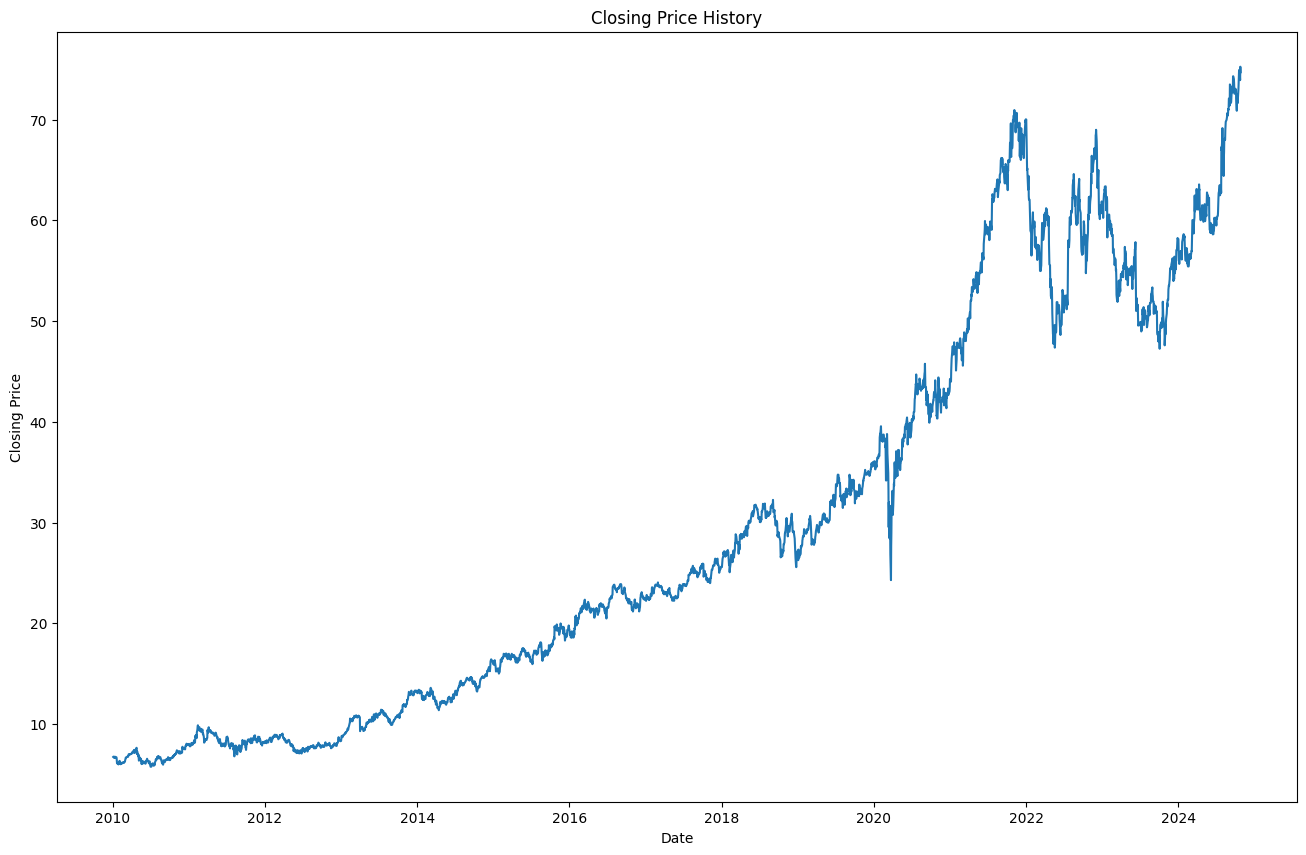

In [132]:
plt.figure(figsize=(16, 10))
plt.plot(df['Date'], df['Close'])
plt.title('Closing Price History')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

Moving Average

In [144]:
df['ma10'] = df['Close'].rolling(10).mean()
fig = go.Figure(data = [go.Candlestick(x = df['Date'],
                open = df['Open'],
                close = df['Close'],
                high = df['High'],
                low = df['Low']),

                go.Scatter(x = df['Date'],
                           y = df['ma10'])])
fig.show()

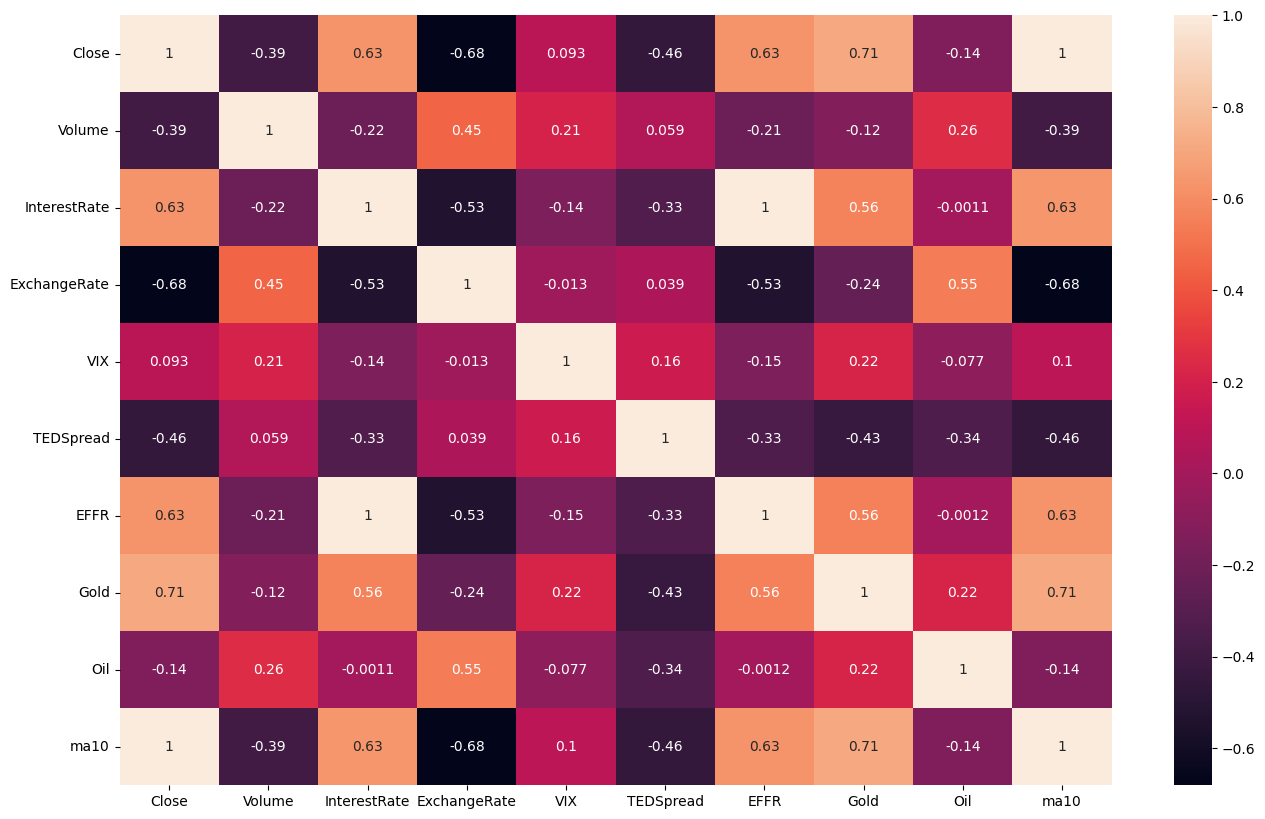

In [134]:
num_df = df.select_dtypes(include = ['float64', 'int64'])
correlation = num_df.iloc[10:].drop(columns = ['Open','High','Low']).corr()
plt.figure(figsize = (16, 10))
sns.heatmap(correlation, annot = True)
plt.show()

Interest Rate and EFFR (Effective Federal Funds Rate) are perfectly correlated --> omit EFFR

In [135]:
new_df = df[['Date','Close', 'InterestRate', 'ExchangeRate', 'VIX', 'TEDSpread', 'Gold', 'Oil']].copy()
previous_vol = [0]
previous_ma10 = [0]
for i in range(0, len(df) - 1):
  previous_vol.append(df.loc[i]['Volume'])
new_df['previous_vol'] = previous_vol

In [136]:
new_df = new_df.iloc[10:].reset_index(drop = True)
new_df.head()

,Date,Close,InterestRate,ExchangeRate,VIX,TEDSpread,Gold,Oil,previous_vol
0,2010-01-18,6.72,0.11,1.4376,17.91,0.19,1130.1,78.00,6981900.0
1,2010-01-19,6.71,0.11,1.4269,17.58,0.19,1139.7,79.02,6981900.0
2,2010-01-20,6.64,0.11,1.4094,18.68,0.20,1112.3,77.62,3156900.0
3,2010-01-21,6.32,0.11,1.4106,22.27,0.19,1102.7,76.08,5761500.0
4,2010-01-22,6.11,0.11,1.4154,27.31,0.19,1089.2,74.54,13422900.0


In [137]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [138]:
ss = StandardScaler()
scaled = ss.fit_transform(new_df.drop(columns = ['Date', 'Close']))
scaled_df = pd.DataFrame(scaled, columns = new_df.drop(columns = ['Date', 'Close']).columns)
new_df2 = pd.concat([new_df[['Date', 'Close']], scaled_df], axis = 1)
new_df2.head()

,Date,Close,InterestRate,ExchangeRate,VIX,TEDSpread,Gold,Oil,previous_vol
0,2010-01-18,6.72,-0.642477,2.180178,-0.066633,-0.344444,-1.215698,0.279394,1.079593
1,2010-01-19,6.71,-0.642477,2.085612,-0.113953,-0.344444,-1.186666,0.326858,1.079593
2,2010-01-20,6.64,-0.642477,1.930947,0.043780,-0.277323,-1.269528,0.261711,-0.180173
3,2010-01-21,6.32,-0.642477,1.941553,0.558562,-0.344444,-1.298560,0.190049,0.677653
4,2010-01-22,6.11,-0.642477,1.983975,1.281265,-0.344444,-1.339386,0.118387,3.200939


In [151]:
X = new_df2.drop(columns = ['Date', 'Close'])
y = new_df2['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

lr = LinearRegression()
model = lr.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(mean_squared_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

67.59535095209259
0.824018834065761


In [152]:
y_pred = model.predict(X)

In [153]:
test = pd.DataFrame({'Date': new_df['Date'], 'y': y, 'y_pred': y_pred})

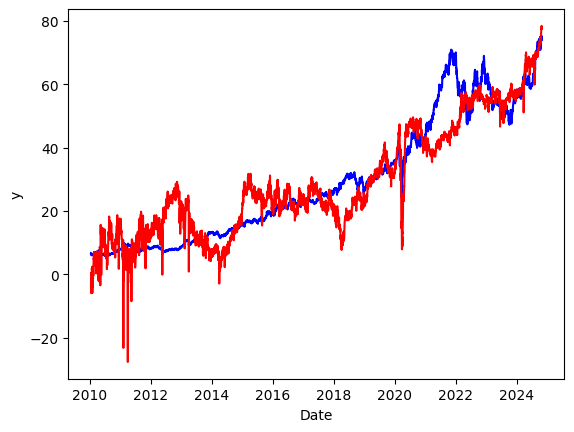

In [155]:
sns.lineplot(data = test, x = 'Date', y = 'y', color = 'blue')
sns.lineplot(data = test, x = 'Date', y = 'y_pred', color = 'red')
plt.show()